# Analyzing datasets combinations

    Notebook version: 1.4 (Jan 04, 2021)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)

    Changes: v.1.0 - First version
             v.1.3 - Implements optimal reconstructions
             v.1.4 - Adapted to the new version of wlweakener.py

In [1]:
# To visualize plots in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt

# Import some libraries that will be necessary for working with data
import numpy as np
from collections import Counter
# from scipy import spatial
# from sklearn import neighbors, datasets

# Local imports
import weaklabels.WLweakener as wlw



## 1. Introduction.

In this notebook we analyze the behavior of sample based estimates of a $C$-dimensional probability vector $\boldsymbol{\eta}$ from binary vector instances.

The main goal is to compare the behavior of a "supervised" estimate, based on a set of labels $\{{\bf y}_k, k=0,\ldots, K-1\}$ generated from $\boldsymbol{\eta}$, and estimates based on weak labels, $\{{\bf b}_k, k=0,\ldots, K-1\}$, generated from some related distribution ${\bf q} = {\bf M}\boldsymbol{\eta}$, where ${\bf M}$ is called a mixing matrix and contains conditional probabilities.

To do so, we will generate a dataset of labels drawn from $\boldsymbol{\eta}$, and one or more datasets of weak labels drawn from ${\bf q}$.

First we define some configurable parameters:

In [2]:
# CONFIGURABLE PARAMETERS FOR THE WHOLE NOTEBOOK
K = 10000                        # Sample size
eta = np.array([0.5, 0.2, 0.3])   # True probability vector
eta = np.array([0.35, 0.3, 0.2, 0.1, 0.03, 0.02])   # True probability vector

# Instead of defining eta at hand, you can generate it at random:
C = 5
alpha = 0.5
eta = np.random.dirichlet(alpha * np.ones(C))
print(eta)

# Weak Label model. Used to generate the data.
# Available options are: quasi_IPL, noisy, random_noise ...
wl_model = 'random_weak'   # 'quasi-IPL'    # 'random_noise'   # 'noisy', 'quasi_IPL'

# Parameters of the weak label model
beta = 0.4

# Virtual label model
# This is the model used to estimate the virtual label matrix
# Available options are: binary, quasi_IPL, M-pinv, M-conv, M-opt, M-opt_conv, ...
vl_model = 'M-pinv'

# Seed
np.random.seed(5)

[0.95392467 0.02607183 0.00195484 0.0048739  0.01317475]


### 1.1. Mixing Matrix.

Based on the selected weak label model, we generate and visualize the corresponding mixing matrix.

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


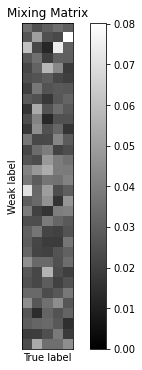

In [3]:
# Number of classes
C = len(eta)   

# Mixing matrix
WLM = wlw.WLmodel(C, model_class=wl_model)
                       
# M = WLM.computeM(C, beta=beta, method=wl_model)
M = WLM.generateM(alpha=0.96, beta=10)
# M = 0.5 * np.eye(C) + 0.5 * M

# Number of weak categories
n_weak = M.shape[0]

# if wl_model == 'quasi-IPL':
#     dec_labels = np.arange(0, 2**C)
# elif wl_model in ['noisy', 'random_noise']:
#     dec_labels = 2**np.arange(C-1, -1, -1)
# else:
#     raise ValueError("dec_labels not implemented for the given wl_model")

# Remove zero rows
flag = np.nonzero(np.sum(M, axis=1))[0]
# M = M[flag, :]   # This is to remove zero rows, which are not relevant
# dec_labels = dec_labels[flag]   # This is to remove zero rows, which are not relevant
print(flag)

# Show:
if n_weak < 5:
    print("Mixing matrix:")
    print(M)
    print(f"Corresponding to weak label indices {dec_labels}")

plt.figure(figsize=(6, 6))
plt.imshow(M, interpolation='nearest', cmap="gray", clim=(0.0, np.max(M))) 
plt.colorbar()
plt.title('Mixing Matrix')
plt.xlabel('True label')
plt.ylabel('Weak label')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [4]:
M[1:5,:]

array([[0.02717706, 0.05004862, 0.02520042, 0.02338775, 0.08025784],
       [0.06067328, 0.02261389, 0.01246734, 0.07430023, 0.03097601],
       [0.02789726, 0.03514635, 0.01981989, 0.03059365, 0.02988799],
       [0.02226537, 0.03117018, 0.05761893, 0.04285231, 0.01847131]])

### 1.2. Weak label priors

In the following we analyze the sparsity of the weak label priors by showing the values of the prior weak label probabilities in increasing order.

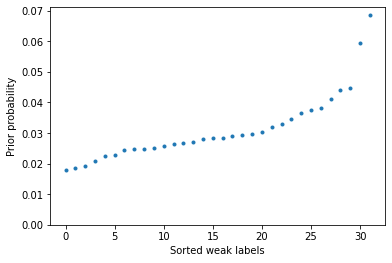

The entropy is 3.4124689212246784 (maximum is 3.4657359027997265)


In [5]:
# True priors
p = M @ eta
h = - p @ np.log(p).T

plt.plot(np.sort(p),'.')
plt.ylim((0, plt.ylim()[1]))
plt.xlabel('Sorted weak labels')
plt.ylabel('Prior probability')
plt.show()

print(f'The entropy is {h} (maximum is {np.log(len(p))})')

### 1.3. Dataset generation.

In the following we will generate a dataset of labels and their corresponding weak labels

In [6]:
# Generate true labels
I = np.eye(C)
iy = np.random.choice(np.arange(0, C), size=K, p=eta)
y = I[iy]

# Generate weak label indices
z = WLM.generateWeak(iy)
print(z)

[ 5 15 16 ... 16  0 24]


### 1.4. Supervised, sample based estimation.

In the supervised setting, ${\bf y}$ is observed an the optimal sample based estimate of $\boldsymbol{\eta}$ (minimizing any Bregman divergence) based on the observed labels is the sample average

In [7]:
f = np.mean(y, axis=0)
print(f"Supervised estimate: {f}")
e2 = np.sum((f - eta)**2)
print(f"Square error: {e2}")

Supervised estimate: [0.9533 0.0275 0.0022 0.0048 0.0122]
Square error: 3.4455866101475934e-06


### 1.5. Learning from weak labels.

There are many ways to estimate $\boldsymbol{\eta}$ from the weak labels. We consider here a representative sample of them:

#### 1.5.1. Reconstruction Matrices

In the following we compute the reconstrution matrices based on left-inverses, using the true weak label priors and estimations based on data

In [8]:
# Compute reconstruction matrices
Y_pinv = wlw.virtual_label_matrix(M, p=None, convex=False)
Y_conv = wlw.virtual_label_matrix(M, p=None, convex=True)
Y_opt = wlw.virtual_label_matrix(M, p=p, convex=False)
Y_opt_conv = wlw.virtual_label_matrix(M, p=p, convex=True)

# Compute estimated priors
z_count = Counter(z)
p_est = np.array([z_count[x] for x in WLM.weak_classes])
p_est = p_est / np.sum(p_est)

# Compute reconstruction matrices
Y_opt_est = wlw.virtual_label_matrix(M, p=p_est, convex=False)
Y_opt_conv_est = wlw.virtual_label_matrix(M, p=p_est, convex=True)

# Set
eta2 = eta.T @ eta
mse_pinv = (np.diag(Y_pinv.T @ Y_pinv) @ p - eta2)
mse_conv = (np.diag(Y_conv.T @ Y_conv) @ p - eta2)
mse_opt = (np.diag(Y_opt.T @ Y_opt) @ p - eta2)
mse_opt_conv = (np.diag(Y_opt_conv.T @ Y_opt_conv) @ p - eta2)

mse_opt_est = (np.diag(Y_opt_est.T @ Y_opt_est) @ p - eta2)
mse_opt_conv_est = (np.diag(Y_opt_conv_est.T @ Y_opt_conv_est) @ p - eta2)


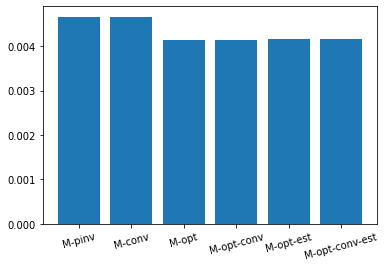

In [9]:
mse_th = {'M-pinv': mse_pinv / K, 'M-conv': mse_conv / K, 'M-opt': mse_opt / K,
          'M-opt-conv': mse_opt_conv / K, 'M-opt-est':  mse_opt_est / K,
          'M-opt-conv-est': mse_opt_conv_est / K}

plt.bar(mse_th.keys(), mse_th.values())
plt.xticks(range(len(mse_th)), mse_th, rotation='15')
plt.axis('tight')
plt.show(block=False)

#### 1.5.1. Averaging virtual labels

If ${\bf z}$ is a sample from distribution ${\bf q}$, and ${\bf V}$ is any left inverse of the mixing matrix (so that ${\bf V}{\bf M} = {\bf I}$ then it can be shown that $\mathbb{E}\{{\bf v}\} = \boldsymbol{\eta}$. Therefore, the sample average of virtual labels is an umbiased estimate of $\boldsymbol{\eta}$.

In [10]:
print(f"Computing virtual labels with method {vl_model}")
v = WLM.virtual_labels(z, vl_model, p=p)
print(f"Virtual labels are: {v}")
f_v = np.mean(v, axis=0)

print(f"Virtual label estimate: {f_v}")
e2 = np.sum((f_v - eta)**2)
print(f"Square error: {e2}")

Computing virtual labels with method M-pinv
Virtual labels are: [[ 0.73328129  1.14645811  0.86659462 -0.64093709 -1.33327143]
 [-0.21256366 -2.53886032  0.92043006  0.58435819  2.34524639]
 [11.74617318  1.76683628  0.64786598 -8.43217212 -4.52725152]
 ...
 [11.74617318  1.76683628  0.64786598 -8.43217212 -4.52725152]
 [ 0.56207676 -1.31430863  0.23935609  1.05350203  0.40957565]
 [-0.84442628 -2.45691418  5.87473609 -0.70631064 -0.9369079 ]]
Virtual label estimate: [ 0.99482675  0.03833277  0.03935082 -0.01644389 -0.05231881]
Square error: 0.007965625044384304


The choice of ${\bf V}$ is relevant. Different left inverses of the mixing matrix may have better behavior under finite samples.

#### 1.5.2. Maximum Likelihood Estimate

The expected value of a virtual label vector can be shown to be equal to the minimizer of the expected log likelihood. This implies that, on average, the average of the virtual label vector and the ML estimate should be assymptotically equivalent. However, for a finite sample size, they can also lead to different results.

The following function computes the ML estimate by means of the EM algorithm.

In [11]:
def computeML(iz, M, f0=None, max_iter=1e10, echo='off'):
    """
    Compute the ML estimate of a probability vector based on weak labels in iz
    and the mixing matrix M.
    The estimation method is based on Expectation-Maximization.
    
    Parameters
    ----------
    iz       :Observed weak labels
    M        :Mixing matrix
    f0       :Initial value of the ML estimate.
    max_iter :Maximum number of iterations.
    echo     :If 'on', output messages are shown

    Returns
    -------
    f_ml     :Maximum likelihood estimate
    """

    # Initialize the estimate.
    if f0 is None:
        C = M.shape[1]   # No. of classes
        f_ml = np.ones(C)/C
    else:
        f_ml = f0

    # Recursive estimation
    iterate = True
    count = 0
    while iterate:
        fi = np.dot(np.diag(f_ml), M.T)[:,iz.astype(int)]
        fi = fi / np.sum(fi, axis=0)
        f_new = np.mean(fi, axis=1)
        count += 1
        iterate = np.any(f_new != f_ml) and count < max_iter
        f_ml = np.copy(f_new)
    
    if echo=='on':
        if count>= max_iter:
            print(f"Stopped before convergence after {max_iter} iterations")
        else:
            print(f"Converged in {count} iterations")

    return f_ml

def computeNLL(iz, M, f):
    """
    Compute the Log-Likelihood function for an estimate f.
    """
    
    I = np.eye(M.shape[0])
    z = I[iz.astype(int)]
    NLL = - np.dot(np.mean(z, axis=0), np.log(np.dot(M, f)))

    return NLL

We can verify that the EM steps monotonically decrease the NLL

Stopped before convergence after 10000 iterations
Iteration 999 out of 1000   eta = [0.95392467 0.02607183 0.00195484 0.0048739  0.01317475]
f_ml = [9.47267166e-01 9.36743998e-03 4.13223097e-02 1.95228748e-03
 9.07965947e-05]
f_v = [ 0.99482675  0.03833277  0.03935082 -0.01644389 -0.05231881]


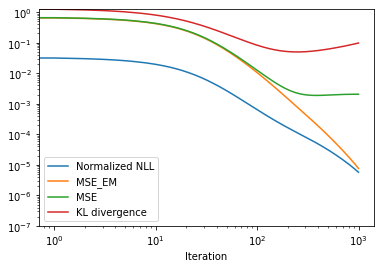

The final estimate is [9.47267166e-01 9.36743998e-03 4.13223097e-02 1.95228748e-03
 9.07965947e-05]
The true label is [0.95392467 0.02607183 0.00195484 0.0048739  0.01317475]


In [12]:
n_it = 1000

# Compute inverted index 
z2i = dict(zip(WLM.weak_classes, range(len(WLM.weak_classes))))

# Transform (decimal) weak labels into their corresponding indices in dec_labels.
iz = np.array([z2i[zi] for zi in z])

# Compute weak label proportions
I = np.eye(M.shape[0])
B = I[iz]
q = np.mean(B, axis=0)

# Compute ML estimate based on iz and M
f_lim = computeML(iz, M, f, max_iter=10000, echo='on')

f = None
NLL, MSE, KL, MSE_EM = [], [], [], []

for i in range(n_it):
    print(f"\rIteration {i} out of {n_it}   ", end="")

    # Apply a single iteration of EM (max_iter=1) to see the evolution
    f_new = computeML(iz, M, f, max_iter=1)
    
    # If the EM has converged, we stop iterating
    if f is not None and np.all(f_new == f):
        break

    # Update EM estimate.
    f = np.copy(f_new)

    # NLL.append(computeNLL(iz, M, f) + np.dot(q, np.log(q)))
    NLL.append(computeNLL(iz, M, f) + q @ np.log(M @ f_lim))
    MSE.append(np.sum((f - eta)**2))
    KL.append(- eta @ np.log(f) + eta @ np.log(eta))
    MSE_EM.append(np.sum((f - f_lim)**2))

print(f"eta = {eta}")
print(f"f_ml = {f}")
print(f"f_v = {f_v}")
its = range(len(NLL))
plt.loglog(its, NLL, label= "Normalized NLL")
plt.loglog(its, MSE_EM, label= "MSE_EM")
plt.loglog(its, MSE, label= "MSE")
plt.loglog(its, KL, label= "KL divergence")
plt.legend(loc='best')
plt.axis('tight')
plt.xlabel('Iteration')
# plt.ylim((1e-7, plt.ylim()[1]))
plt.ylim((1e-7, max([max(MSE), max(KL), max(MSE_EM), max(NLL)])))
plt.show()
print(f"The final estimate is {f}")
print(f"The true label is {eta}")


In the figure above, we can expect that both the *Normalized NLL* and the *MSE_EM* converge to zero, because both measures are based on the comparison with the limit value. The curves are usefull to verify that the error measures decrease monotonically.

The *MSE* and the *KL divergence*, which are computed with respect to the true probability vector, $\boldsymbol{\eta}$, do not usually converge to zero, because, due to the finite sample size, the EM iterations does not converge exactly to $\boldsymbol{\eta}$, but to a close value, ${\bf f}_\text{lim}$. Yoy may check that the limit values of these error measures are smaller when the sample size increases.

In [13]:
f_ml = computeML(iz, M, max_iter=1000, echo='on')

print(f"ML estimate: {f_ml}")
e2 = np.sum((f_ml - eta)**2)
print(f"Square error: {e2}")

Stopped before convergence after 1000 iterations
ML estimate: [9.47267166e-01 9.36743998e-03 4.13223097e-02 1.95228748e-03
 9.07965947e-05]
Square error: 0.0020528823438657547


## 2. Combination of datasets

In the following experiments we explore the combination of a fully labeled dataset with a weakly labeled dataset. We show that the beharior of the estimate based on virtual label depends on the choice of the virtual label vector.

The experiment demonstrates that, though different virtual label matrices can be asymptotically equivalent for the estimation of the probability vector, they show a different behavior under finite samples. 

### 2.1. Weighting samples

In the following experiments we explore virtual matrices ${\bf V}$ which are a combination of virtual matrices from the original datasets, i.e. they have the form ${\bf V} = (w{\bf V}_0, (1-w){\bf V}_1)$ where ${\bf V}_0$ and ${\bf V}_1$ are virtual matrices for the original datasets. We show that the empirical mse depends on $w$, and there is an optimal choice for $w$.

Note that the experiment does not explore all posible virtual matrices (i.e. all left inverses of the mixing matrix), but only those that are a composition of two fixed virtual matrices.

100

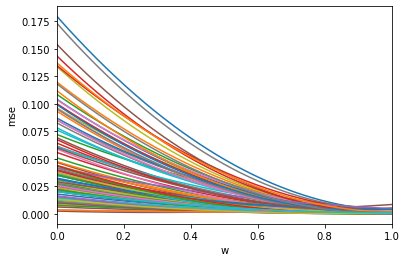

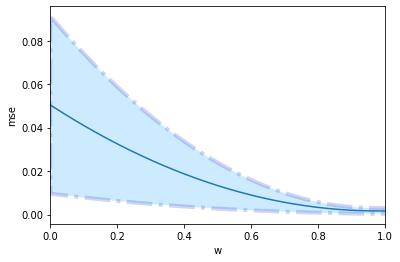

In [14]:
n_sim = 100
K = 50

# Number of classes
C = len(eta)   
I_C = np.eye(C)

# Mixing matrix
wl_model = 'quasi-IPL'
WLM = wlw.WLmodel(C, model_class=wl_model)
M = WLM.computeM()

mse = []
for n in range(n_sim):

    if (n+1)/1*1 == n+1:
        print(f"\r{n+1}", end="")

    # Generate fully labeled dataset
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I_C[iy]

    # Generate weakly labeled dataset
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    z = WLM.generateWeak(iy)

    # Supervised estimation
    f = np.mean(y, axis=0)

    # Estimation with virtual labels (M and dec_labels are not used if vl_model=='Mproper')
    v = WLM.virtual_labels(z, method=vl_model)
    v = WLM.virtual_labels(z, method=vl_model)
    
    f_v = np.mean(v, axis=0)
    
    # Combination of virtual labels. 
    # Al values of w provide consistent virtual matrices. However, the msw for a finite sample depends on w.
    w = np.arange(0, 1, 0.001)[:, np.newaxis]
    f_est = f * w + f_v * (1 - w)
    mse_n = np.sum((f_est - eta)**2, axis=1)
    mse.append(mse_n)

plt.plot(w.flatten(), np.array(mse).T)
plt.xlabel('w')
plt.ylabel('mse')
plt.xlim([0, 1])
plt.show()

mse_mean =  np.mean(np.array(mse), axis=0)
mse_std = np.std(np.array(mse), axis=0)
plt.plot(w.flatten(), mse_mean)
plt.fill_between(w.flatten(), mse_mean - mse_std, mse_mean + mse_std,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)
plt.xlabel('w')
plt.ylabel('mse')
plt.xlim([0, 1])
plt.show()


### 2.2. Optimal weight versus noise level

The following experiment shows that the relation between the noise level and the optimal weight might be non-trivial.

In [15]:
Ktrue = 200       # Number of clean labels
Kweak = 200       # Number of weak labels       
qTrue = float(Ktrue)/(Ktrue + Kweak)
qWeak = float(Kweak)/(Ktrue + Kweak)

n_betas = 10
beta_set = np.linspace(0, 1-1.0/n_betas, n_betas)


n_sim = 200      # Number of experiments for each value of eta.
wmse = []
wkld = []
w = np.linspace(0, 1, 101)[:, np.newaxis]/ qTrue

for beta in beta_set:

    print(f"\rBeta = {beta}", end="")
    
    # Mixing matrix
    M_b = WLM.computeM(beta=beta)
    # if wl_model == 'quasi_IPL':
    #     dec_labels_b = np.arange(0, 2**C)
    # elif wl_model in ['noisy', 'random_noise']:
    #     dec_labels_b = 2**np.arange(C-1, -1, -1)
    # else:
    #    raise ValueError("dec_labels not implemented for the given wl_model")

    # Compute virtual matrix (this is to compute virtual labels in a more efficient way
    # than the current implementation of ComputeVirtual in WLweakener)
    V = np.linalg.pinv(M_b)    
    
    np.random.seed(0)
    mse = []
    kld = []
    for n in range(n_sim):

        # Generate fully labeled dataset
        iy = np.random.choice(np.arange(0, C), size=Ktrue, p=eta)
        y = I_C[iy]

        # Generate weakly labeled dataset
        iy2 = np.random.choice(np.arange(0, C), size=Kweak, p=eta)
        z2 = WLM.generateWeak(iy2)

        # Compute inverted index 
        z2i = dict(zip(WLM.weak_classes, range(len(WLM.weak_classes))))
        # Transform (decimal) weak labels into their corresponding indices in dec_labels.
        iz2 = np.array([z2i[zi] for zi in z2])
    
        # Supervised estimation
        f = np.mean(y, axis=0)

        # Estimation with virtual labels
        # v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
        v = V.T[iz2.astype(int)]
        f_v = np.mean(v, axis=0)
        
        # if np.any(f_v<=0):
        #     print "f_v = {0}".format(f_v)

        # Weighted average
        f_est = f * w * qTrue + f_v * (1 - w * qTrue)
        # f_est = f * w + f_v * (1 - w)
        mse_n = np.sum((f_est - eta)**2, axis=1)
        mse.append(mse_n)
        
        kld_n = - np.dot(eta, np.log(f_est.T)) 
        kld.append(kld_n)

    mse_mean =  np.mean(np.array(mse), axis=0)
    imin = np.argmin(mse_mean)
    wmse.append(w[imin][0])
    
    kld_mean =  np.mean(np.array(kld), axis=0)
    imin = np.argmin(kld_mean)
    wkld.append(w[imin][0])

Beta = 0.0

<ipython-input-15-d2cc0159a4d2>:67: RuntimeWarning: divide by zero encountered in log
  kld_n = - np.dot(eta, np.log(f_est.T))


Beta = 0.1

<ipython-input-15-d2cc0159a4d2>:67: RuntimeWarning: invalid value encountered in log
  kld_n = - np.dot(eta, np.log(f_est.T))


Beta = 0.90000000000000014

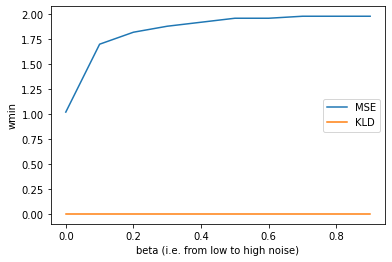

In [16]:
plt.plot(beta_set, np.array(wmse).flatten(), label="MSE")
plt.plot(beta_set, np.array(wkld).flatten(), label="KLD")
plt.xlabel('beta (i.e. from low to high noise)')
plt.ylabel('wmin')
plt.legend(loc='best')
plt.show()

The last experiment shows several important issues:

* The optimal weights could be independent on the choice of the proper loss
* The average of the virtual labels can be out of the probability simplex. In this respect, the optimal probability estimate should be computed with the constraint that the estimate lies inside the probability simplex. (Negative values are the cause of the anomalies in the KL divergence weighs that may appear in the above plot).


### 2.3. A comparison between EM, virtual labels and the optimal weights

The following section shows that, despite ML-EM and weak losses may lead to different results, they can show very similar performance, though the results may depend on the selection of the configurable parameters (in particular, label proportions and mixing matrix).

In [17]:
Ktrue = 40       # Number of clean labels
Kweak = 40       # Number of weak labels       
qTrue = float(Ktrue)/(Ktrue + Kweak)
qWeak = float(Kweak)/(Ktrue + Kweak)

n_betas = 10
beta_set = np.linspace(0, 1.0-1.0/n_betas, n_betas)
n_sim = 200      # Number of experiments for each value of eta.
wmse = []
w = np.linspace(0, 1, 101)[:, np.newaxis]/ qTrue

mse_w = []
mse_v = []
mse_ml = []
wtest = []
wpseudo = []

for beta in beta_set:

    print(f"\rBeta = {beta}", end="")
    
    # Mixing matrix
    M_b = WLM.computeM(beta=beta)
    # if wl_model == 'quasi_IPL':
    #     dec_labels_b = np.arange(0, 2**C)
    # elif wl_model in ['noisy', 'random_noise']:
    #     dec_labels_b = 2**np.arange(C-1, -1, -1)
    # else:
    #    raise ValueError("dec_labels not implemented for the given wl_model")
    # Remove zero rows
    dec_labels_b = WLM.weak_classes
    flag = np.nonzero(np.sum(M_b, axis=1))[0]
    M_b = M_b[flag, :]   # This is to remove zero rows, which are not relevant
    dec_labels_b = dec_labels_b[flag]   # This is to remove zero rows, which are not relevant
        
    # Compute virtual matrix 
    # Note that the virtual label matrix is equivalent to the (transpose of the) matrix of virtual labels 
    # corresponding to the weak labels in dec_labels.
    # Computing the virtual matrix here we avoid computing a pseudoinverse inside the "for" loop below
    V = wlw.virtual_label_matrix(M_b, convex=False)
    
    # Compute combined mixing matrix
    M2 = np.vstack((qTrue*np.eye(C), qWeak*M_b))
    V2 = np.linalg.pinv(M2)

    np.random.seed(0)
    mse_wn = []
    mse_vn = []
    mse_mln = []

    for n in range(n_sim):

        # #####################
        # ## Dataset generation
        
        # Generate fully labeled dataset
        iy = np.random.choice(np.arange(0, C), size=Ktrue, p=eta)
        y = I_C[iy]

        # Generate weakly labeled dataset
        iy2 = np.random.choice(np.arange(0, C), size=Kweak, p=eta)
        z = WLM.generateWeak(iy2)

        # Compute inverted index 
        z2i = dict(zip(dec_labels_b, range(len(dec_labels_b))))
        # Transform (decimal) weak labels into their corresponding indices in dec_labels.
        iz = np.array([z2i[zi] for zi in z])

        # Join datasets
        iz2 = np.hstack((iy, iz + C))
        
        # #######################
        # ## Weighted combination
        
        # Supervised estimation with dataset 0
        f = np.mean(y, axis=0)

        # Estimation with virtual labels and dataset 1
        # v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
        v = V.T[iz.astype(int)]
        
        f_v = np.mean(v, axis=0)
        
        # Weighted average
        f_est = f*w*qTrue + f_v*(1-w*qTrue)
        mse_wn.append(np.sum((f_est - eta)**2, axis=1))

        # #######################
        # ## (pinv) M-proper loss
        v2 = V2.T[iz2.astype(int)]
        f_v2 = np.mean(v2, axis=0)
        mse_vn.append(np.sum((f_v2 - eta)**2))        
        
        # ##############
        # ## ML estimate
        f_ml = computeML(iz2, M2, f0=None, max_iter=1000, echo='off')
        mse_mln.append(np.sum((f_ml - eta)**2))

    mse_mean =  np.mean(np.array(mse_wn), axis=0)
    imin = np.argmin(mse_mean)
    wmse.append(w[imin][0])
    mse_w.append(np.min(mse_mean))

    mse_v.append(np.mean(np.array(mse_vn), axis=0))
    mse_ml.append(np.mean(np.array(mse_mln), axis=0))
    
    F11 = qWeak**2 * np.linalg.norm(np.dot(M, V), 'fro')**2
    F10 = qWeak**2 * np.linalg.norm(M, 'fro')**2
    F01 = qTrue**2 * np.linalg.norm(V, 'fro')**2
    F00 = qTrue**2*C
    w0= qTrue*C/(F00 + F10)
    
    wtest.append(qTrue*(F11+F01) / (qTrue**2*(F11+F01) + qWeak**2*(F00+F10)))
    wpseudo.append((w0/qTrue-1))
    
print(mse_w)
print(mse_v)
print(mse_ml)

Beta = 0.90000000000000014[0.0010851900396455381, 0.0018168207102644066, 0.0018834357954539138, 0.0019214005810197165, 0.0019597987980202462, 0.001978252974724252, 0.0019873898294306422, 0.0019984737866783116, 0.002019203894684286, 0.0020114705061244687]
[0.001086811661547958, 0.002369092357610607, 0.0020631168220160965, 0.0019472887037737467, 0.0019690643298960826, 0.001994896481925531, 0.0020555215951605856, 0.002183733291377843, 0.0024453973844203595, 0.002589136664824374]
[0.001086811661547958, 0.0011800740735296437, 0.0013351756816691914, 0.0014044972840670674, 0.0014955341586172632, 0.0015300460698066682, 0.00165089407407089, 0.0017478324025317327, 0.0018265852976806786, 0.0018770900151798998]


The next figure shows the MSE obtained with ML-EM (red), virtual labels based on the left inverse of ${\bf M}$ provided by `pinv` (blue) and virtual labels with the empirically optimal weights. The results may depend on the choice of the mixing matrix, but in general there is a good adjustment between ML and virtual labels. Also, there seem to exist some optimal weight providing and MSE equivalent to ML.

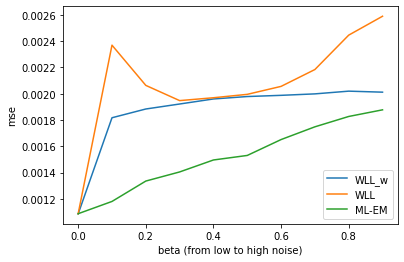

[0.001086811661547958, 0.0011800740735296437, 0.0013351756816691914, 0.0014044972840670674, 0.0014955341586172632, 0.0015300460698066682, 0.00165089407407089, 0.0017478324025317327, 0.0018265852976806786, 0.0018770900151798998]


In [18]:
plt.plot(beta_set, np.array(mse_w).flatten(), label="WLL_w")
plt.plot(beta_set, np.array(mse_v).flatten(), label="WLL")
plt.plot(beta_set, np.array(mse_ml).flatten(), label="ML-EM")
plt.xlabel('beta (from low to high noise)')
plt.ylabel('mse')
# plt.ylim((0, np.max(mse_w)+0.001))
plt.legend(loc='best')
plt.show()

print(mse_ml)

In the draft paper I have derived some equations to compute the optimal weights of a combination of two given virtual matrices.
These weights are computed below, for different values of beta.

In [19]:
n_betas = 20
beta_set = np.linspace(0, 1-1.0/n_betas, n_betas)

wtest = []
wpseudo = []

for beta in beta_set:

    print(f"\rBeta = {beta}", end="")

    # Mixing matrix
    M = WLM.computeM(beta=beta)

    # Compute virtual matrix (this is to compute virtual labels in a more efficient way
    # than the current implementation of ComputeVirtual in WLweakener)
    V = np.linalg.pinv(M)

    # Compute combined mixing matrix
    M2 = np.vstack((qTrue*np.eye(C), qWeak*M))
    V2 = np.linalg.pinv(M2)

    F11 = qWeak**2 * np.linalg.norm(np.dot(M, V), 'fro')**2
    F10 = qWeak**2 * np.linalg.norm(M, 'fro')**2
    F01 = qTrue**2 * np.linalg.norm(V, 'fro')**2
    F00 = qTrue**2*C
    w0= qTrue*C/(F00 + F10)
    
    wtest.append(qTrue*(F11 + F01) / (qTrue**2*(F11+F01) + qWeak**2*(F00+F10)))
    wpseudo.append(w0/qTrue-1)

Beta = 0.95

Next figure shows the difference between the empirically optimal weights (blue), the prediction (green) and a slight modification of the prediction that seems to improve the adjustment between predicted and optimal weights in a significant manner. No conclusions can be made yet, because there could be errors in the derived equations (to be checked).

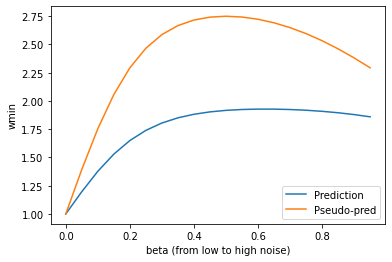

[1.04 1.76 1.84 1.88 1.92 1.96 1.96 1.98 1.98 1.98]


In [20]:
# plt.plot(beta_set, np.array(wmse).flatten(), label="Empirical")
plt.plot(beta_set, np.array(wtest).flatten(), label="Prediction")
plt.plot(beta_set, np.array(wpseudo).flatten(), label="Pseudo-pred")
plt.xlabel('beta (from low to high noise)')
plt.ylabel('wmin')
plt.legend(loc="best")
plt.show()
print(np.array(wmse).flatten())

In [21]:
beta_set = np.linspace(0, 1, 21)
print(beta_set)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
